## Remove duplicate lines

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])


## Duplicate rows with multiple labels
change path to annotation file to flatten the annotations for each culture

In [5]:
persian_data = pd.read_csv("../new_data/Persian/persian_annotations.csv")
cols = ["id", "filename","emotions","emoji","gender","confidence","comment","intensity"]
contents = []
for i in range(0, persian_data.shape[0]):
    row = persian_data.iloc[i]
    for emotion in row['emotions'].split(','):
        # for emoji in row['emoji'].split(','):
        contents.append([row["id"], row["filename"], emotion, row['emoji'], row["gender"], row["confidence"],
                     row["comment"], row["intensity"]])
p_flattened_df = pd.DataFrame(columns=cols, data=contents)

# flattened_df
na_data = pd.read_csv("../new_data/NA/na_annotations.csv")
contents = []
for i in range(0, na_data.shape[0]):
    row = na_data.iloc[i]
    for emotion in row['emotions'].split(','):
        # for emoji in row['emoji'].split(','):
        contents.append([row["id"], row["filename"], emotion, row['emoji'], row["gender"], row["confidence"],
                     row["comment"], row["intensity"]])
na_flattened_df = pd.DataFrame(columns=cols, data=contents)

In [16]:
na_emotion_count = na_flattened_df['emotions'].value_counts()
p_emotion_count = p_flattened_df['emotions'].value_counts()
em = pd.concat([na_emotion_count, p_emotion_count], axis=1, keys=['NA', 'P'])
em

,NA,P
annoyed,109,134
disgust,97,54
anger,90,131
contempt,78,97
none,73,91
furious,66,89
hatred,27,74


### Frequency of emotions before voting

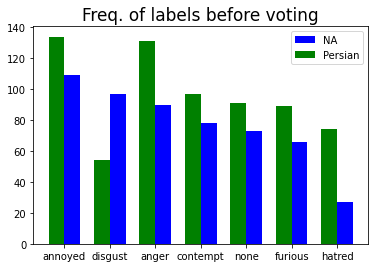

In [22]:
ind = np.arange(len(em))
width = 0.35
ax = plt.subplot(111)
ax.bar(ind+width/2, em['NA'], width=width,color='b', align='center')
ax.bar(ind-width/2, em['P'], width=width,color='gold', align='center')
ax.legend(('NA','Persian'))
plt.xticks(ind, em.index)
plt.title("Freq. of labels before voting", fontsize=17)
plt.show()

<AxesSubplot:title={'center':'Freq. of labels before voting'}>

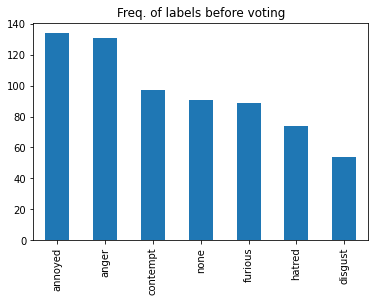

In [11]:

p_flattened_df['emotions'].value_counts().plot(kind='bar', title='Freq. of labels before voting')

<AxesSubplot:>

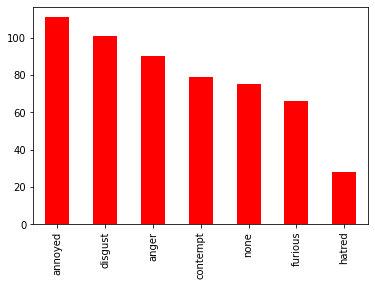

In [13]:
na_flattened_df['emotions'].value_counts().plot(kind='bar', color='red')

### Flattening emojis into new columns
(No need for this right now)

In [3]:
emoji_expanded = flattened_df['emoji'].str.split(',', expand=True)
emoji_expanded.columns = ['emoji'+str(i) for i in emoji_expanded.columns]
flattened_df_concat = pd.concat([flattened_df,emoji_expanded], axis=1)

NameError: name 'flattened_df' is not defined

## Emotion Voting

              filename  gender            emotions
0    persian/vid_1.mp4    male           [annoyed]
1   persian/vid_10.mp4    male          [contempt]
2   persian/vid_11.mp4    male          [contempt]
3   persian/vid_12.mp4    male          [contempt]
4   persian/vid_13.mp4    male             [anger]
5   persian/vid_14.mp4  female              [none]
6   persian/vid_15.mp4    male            [hatred]
7   persian/vid_16.mp4    male          [contempt]
8   persian/vid_17.mp4    male          [contempt]
9   persian/vid_18.mp4  female           [disgust]
10  persian/vid_19.mp4    male              [none]
11   persian/vid_2.mp4    male           [annoyed]
12  persian/vid_20.mp4    male          [contempt]
13  persian/vid_21.mp4    male              [none]
14  persian/vid_22.mp4  female           [annoyed]
15  persian/vid_23.mp4  female          [contempt]
16  persian/vid_24.mp4  female  [contempt, hatred]
17  persian/vid_25.mp4  female              [none]
18  persian/vid_26.mp4  female 

<AxesSubplot:title={'center':'Freq. of emotions after voting'}>

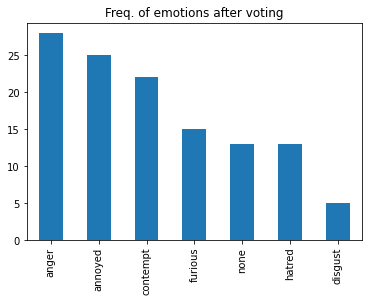

In [25]:
# p_labels_df = p_flattened_df.groupby(['filename', 'gender'])['emotions'].agg(pd.Series.mode).to_frame()
# p_labels_df = p_flattened_df.groupby(['filename', 'gender'])['emotions'].apply(lambda x: list(x.mode()))
# labels_df.to_csv("../new_data/labels.csv", index='filename')
p_labels_df = pd.read_csv("../new_data/Persian/labels.csv")
p_labels_df['emotions'] = p_labels_df['emotions'].apply(eval)
print(p_labels_df.head(20))
to_1D(p_labels_df["emotions"]).value_counts().plot(kind='bar', title='Freq. of emotions after voting', ylabel='')
# flattened_df['emotions'].value_counts()

<AxesSubplot:title={'center':'Freq. of emotions after voting'}>

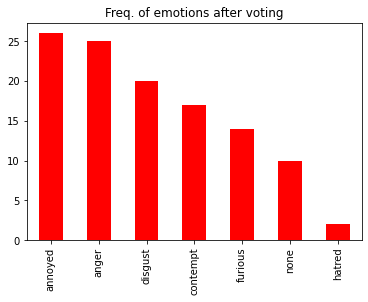

In [26]:
# na_labels_df = na_flattened_df.groupby(['filename', 'gender'])['emotions'].apply(lambda x: list(x.mode()))
# na_labels_df.to_csv("../new_data/na_labels.csv", index='filename')
na_labels_df = pd.read_csv("../new_data/NA/na_labels.csv")
na_labels_df['emotions'] = na_labels_df['emotions'].apply(eval)
# print(na_labels_df.head(20))
to_1D(na_labels_df["emotions"]).value_counts().plot(kind='bar', title='Freq. of emotions after voting', ylabel='', color='red')

In [27]:
na_emotion_count = to_1D(na_labels_df["emotions"]).value_counts()
p_emotion_count = to_1D(p_labels_df['emotions']).value_counts()
em = pd.concat([na_emotion_count, p_emotion_count], axis=1, keys=['NA', 'P'])
em

,NA,P
annoyed,26,25
anger,25,28
disgust,20,5
contempt,17,22
furious,14,15
none,10,13
hatred,2,13


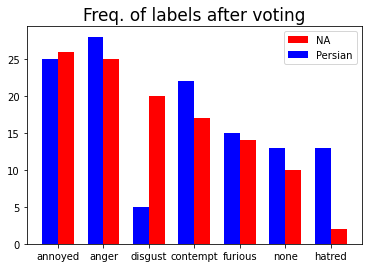

In [29]:
ind = np.arange(len(em))
width = 0.35
ax = plt.subplot(111)
ax.bar(ind+width/2, em['NA'], width=width,color='r', align='center')
ax.bar(ind-width/2, em['P'], width=width,color='b', align='center')
ax.legend(('NA','Persian'))
plt.xticks(ind, em.index)
plt.title("Freq. of labels after voting", fontsize=17)
plt.show()

## Emoji Voting

In [30]:
# persian_data = pd.read_csv("../new_data/persian_annotations.csv")
cols = ["id", "filename","emotions","emoji","gender","confidence","comment","intensity"]
contents = []
for i in range(0, na_data.shape[0]):
    row = na_data.iloc[i]
    for emoji in row['emoji'].split(','):
        # for emoji in row['emoji'].split(','):
        contents.append([row["id"], row["filename"], row['emotions'], emoji, row["gender"], row["confidence"],
                     row["comment"], row["intensity"]])
na_emoji_flattened_df = pd.DataFrame(columns=cols, data=contents)

contents =[]
for i in range(0, persian_data.shape[0]):
    row = persian_data.iloc[i]
    for emoji in row['emoji'].split(','):
        # for emoji in row['emoji'].split(','):
        contents.append([row["id"], row["filename"], row['emotions'], emoji, row["gender"], row["confidence"],
                     row["comment"], row["intensity"]])
p_emoji_flattened_df = pd.DataFrame(columns=cols, data=contents)


In [31]:
na_emoji_count = na_emoji_flattened_df['emoji'].value_counts()
p_emoji_count = p_emoji_flattened_df['emoji'].value_counts()
em = pd.concat([na_emoji_count, p_emoji_count], axis=1, keys=['NA', 'P'])
em

,NA,P
furious,68,55
angry,65,106
hatred,62,72
unamused,60,86
expressionless,52,25
nauseated,52,15
rollingeyes,47,25
triumph,36,81
neutral,36,24
weary,30,51


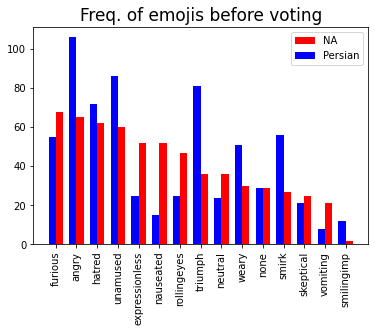

In [34]:
ind = np.arange(len(em))
width = 0.35
ax = plt.subplot()
ax.bar(ind+width/2, em['NA'], width=width,color='r', align='center')
ax.bar(ind-width/2, em['P'], width=width,color='b', align='center')
ax.legend(('NA','Persian'))
plt.xticks(ind, em.index, rotation='vertical')
plt.title("Freq. of emojis before voting", fontsize=17)
plt.show()

### Voting:

In [27]:
## pivot_table = emoji_flattened_df.pivot_table(index='filename', columns='emoji', values='emotions', aggfunc='', fill_value=0)

## same as pivot_table
# df = emoji_flattened_df.groupby(['filename', 'emoji'])['emoji'].count()\
#     .unstack(fill_value=0) \
#     .rename_axis(None, axis=1)

## apply() returns each mode in a separate row
# labels_df = emoji_flattened_df.groupby(['filename'])['emoji'].apply(pd.Series.mode).to_frame()
labels_df = emoji_flattened_df.groupby(['filename', 'gender'])['emoji'].apply(lambda x: list(x.mode()))
# print(labels_df.head(10))
# #labels_df.to_csv("../new_data/emoji_labels.csv")
# emoji_flattened_df['emoji'].value_counts()

labels_df.to_csv("../new_data/na_emoji_labels.csv")

In [37]:
# labels_df.to_csv("../new_data/emoji_labels.csv")
na_emoji_labels = pd.read_csv("../new_data/NA/na_emoji_labels.csv")
p_emoji_labels = pd.read_csv("../new_data/Persian/emoji_labels.csv")
p_emoji_labels["emoji"], na_emoji_labels["emoji"] = p_emoji_labels["emoji"].apply(eval), na_emoji_labels["emoji"].apply(eval)
p_emoji_count = to_1D(p_emoji_labels["emoji"]).value_counts()
na_emoji_count = to_1D(na_emoji_labels["emoji"]).value_counts()
em = pd.concat([na_emoji_count, p_emoji_count], axis=1, keys=['NA', 'P'])
em
# np.sum(to_1D(emoji_labels["emoji"]).value_counts())

,NA,P
expressionless,19.0,2.0
unamused,19.0,29.0
furious,16.0,10.0
angry,16.0,32.0
neutral,12.0,8.0
rollingeyes,12.0,8.0
nauseated,11.0,2.0
hatred,9.0,15.0
none,7.0,2.0
weary,6.0,12.0


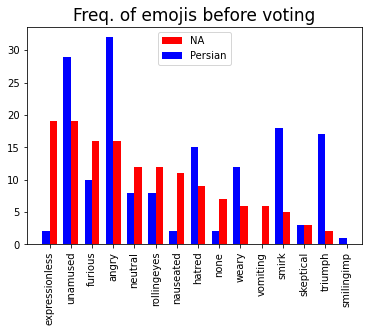

In [38]:
ind = np.arange(len(em))
width = 0.35
ax = plt.subplot()
ax.bar(ind+width/2, em['NA'], width=width,color='r', align='center')
ax.bar(ind-width/2, em['P'], width=width,color='b', align='center')
ax.legend(('NA','Persian'))
plt.xticks(ind, em.index, rotation='vertical')
plt.title("Freq. of emojis before voting", fontsize=17)
plt.show()

### Average of reported intensity

In [14]:
labels_df = pd.read_csv("../new_data/labels.csv", index_col='filename')

In [15]:
average_intensity = flattened_df.groupby(['filename'])['intensity'].mean()
labels_df = pd.concat([labels_df, average_intensity], axis=1)
labels_df

,gender,emotions,intensity
filename,,,
persian/vid_1.mp4,male,['annoyed'],2.500000
persian/vid_10.mp4,male,['contempt'],2.500000
persian/vid_11.mp4,male,['contempt'],2.625000
persian/vid_12.mp4,male,['contempt'],2.400000
persian/vid_13.mp4,male,['anger'],1.750000
...,...,...,...
persian/vid_93.mp4,female,['hatred'],3.666667
persian/vid_94.mp4,male,['none'],1.500000
persian/vid_95.mp4,male,"['contempt', 'hatred']",3.250000


## Correlation between emotions
Before voting on them

In [24]:
df = p_flattened_df.groupby(['filename', 'gender', 'emotions'])['emotions'].count()\
    .unstack(fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1)
df

,filename,gender,anger,annoyed,contempt,disgust,furious,hatred,none
0,persian/vid_1.mp4,male,0,3,0,1,0,0,2
1,persian/vid_10.mp4,male,0,1,2,1,0,0,2
2,persian/vid_11.mp4,male,0,2,3,1,0,0,2
3,persian/vid_12.mp4,male,0,1,2,0,0,0,2
4,persian/vid_13.mp4,male,4,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...
91,persian/vid_93.mp4,female,3,0,1,2,2,4,0
92,persian/vid_94.mp4,male,1,1,1,0,0,0,3
93,persian/vid_95.mp4,male,1,1,2,0,0,2,2
94,persian/vid_96.mp4,male,0,0,3,0,1,0,1


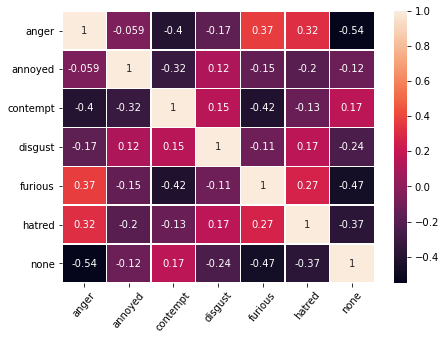

In [25]:
emotions_corr = df.corr(method = "pearson")
emotions_corr

fig, ax = plt.subplots(figsize = (7,5))
sn.heatmap(emotions_corr, annot=True, linewidths=.5, vmin=-0.55, vmax=1.0)
plt.xticks(rotation=50)
plt.savefig("heatmap.png", dpi = 300)

In [31]:
import krippendorff
print("Krippendorff's alpha for nominal metric: ", krippendorff.alpha(value_counts=df.drop(['filename','gender'], axis=1).values,
                                                                          level_of_measurement='nominal'))


Krippendorff's alpha for nominal metric:  0.25390804811850987


## Emoji correlation and K's alpha:

## NA

In [8]:
df = na_emoji_flattened_df.groupby(['filename', 'gender', 'emoji'])['emoji'].count()\
    .unstack(fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1)
emoji_corr = df.corr(method = "pearson")

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format
emoji_corr

,angry,expressionless,furious,hatred,nauseated,neutral,none,rollingeyes,skeptical,smilingimp,smirk,triumph,unamused,vomiting,weary
angry,1.00,-0.23,-0.06,0.19,-0.22,-0.25,-0.04,0.13,-0.16,-0.02,-0.15,0.05,-0.06,-0.15,0.12
expressionless,-0.23,1.00,-0.29,-0.32,-0.19,0.28,0.02,0.12,0.18,-0.09,0.08,-0.18,0.34,-0.16,-0.19
furious,-0.06,-0.29,1.00,0.51,-0.19,-0.22,-0.21,-0.29,-0.20,0.24,-0.19,0.49,-0.32,-0.14,-0.15
hatred,0.19,-0.32,0.51,1.00,-0.22,-0.24,-0.24,-0.22,-0.23,0.11,-0.19,0.48,-0.33,-0.15,-0.06
nauseated,-0.22,-0.19,-0.19,-0.22,1.00,-0.19,-0.15,-0.19,-0.18,-0.07,-0.12,-0.15,-0.21,0.46,0.25
neutral,-0.25,0.28,-0.22,-0.24,-0.19,1.00,0.06,0.04,0.12,-0.06,0.08,-0.17,-0.03,-0.12,-0.15
none,-0.04,0.02,-0.21,-0.24,-0.15,0.06,1.00,0.03,0.18,-0.07,0.13,-0.22,0.09,-0.12,-0.18
rollingeyes,0.13,0.12,-0.29,-0.22,-0.19,0.04,0.03,1.00,0.11,-0.09,0.09,-0.18,0.21,-0.15,-0.10
skeptical,-0.16,0.18,-0.20,-0.23,-0.18,0.12,0.18,0.11,1.00,-0.06,0.37,-0.16,0.13,-0.12,-0.11
smilingimp,-0.02,-0.09,0.24,0.11,-0.07,-0.06,-0.07,-0.09,-0.06,1.00,-0.06,0.03,-0.10,-0.04,-0.06


## Persian

In [9]:
df = p_emoji_flattened_df.groupby(['filename', 'gender', 'emoji'])['emoji'].count()\
    .unstack(fill_value=0) \
    .reset_index() \
    .rename_axis(None, axis=1)
emoji_corr = df.corr(method = "pearson")

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format
emoji_corr

,angry,expressionless,furious,hatred,nauseated,neutral,none,rollingeyes,skeptical,smilingimp,smirk,triumph,unamused,vomiting,weary
angry,1.00,-0.22,0.21,0.30,0.05,-0.20,-0.27,-0.26,-0.14,-0.07,-0.39,0.32,-0.32,0.03,-0.07
expressionless,-0.22,1.00,-0.05,-0.10,0.11,0.26,-0.15,0.06,-0.07,-0.17,-0.03,-0.09,-0.01,-0.08,0.16
furious,0.21,-0.05,1.00,0.54,-0.11,-0.19,-0.26,-0.25,-0.19,-0.07,-0.28,0.53,-0.39,0.05,-0.20
hatred,0.30,-0.10,0.54,1.00,-0.03,-0.28,-0.20,-0.27,-0.27,-0.00,-0.29,0.41,-0.41,0.03,-0.12
nauseated,0.05,0.11,-0.11,-0.03,1.00,-0.15,-0.16,-0.04,-0.12,-0.11,-0.04,0.15,0.04,-0.09,0.20
neutral,-0.20,0.26,-0.19,-0.28,-0.15,1.00,0.26,0.33,0.03,0.00,-0.02,-0.30,0.15,-0.11,-0.17
none,-0.27,-0.15,-0.26,-0.20,-0.16,0.26,1.00,0.12,0.11,0.21,0.21,-0.33,0.00,-0.09,-0.21
rollingeyes,-0.26,0.06,-0.25,-0.27,-0.04,0.33,0.12,1.00,0.14,-0.05,0.01,-0.30,0.33,0.11,-0.10
skeptical,-0.14,-0.07,-0.19,-0.27,-0.12,0.03,0.11,0.14,1.00,-0.14,0.08,-0.24,0.14,-0.05,-0.12
smilingimp,-0.07,-0.17,-0.07,-0.00,-0.11,0.00,0.21,-0.05,-0.14,1.00,0.12,-0.00,-0.04,0.08,-0.13


In [36]:
import krippendorff
print("Krippendorff's alpha for NA/emojis: ", krippendorff.alpha(value_counts=df.drop(['filename','gender'], axis=1).values,
                                                                          level_of_measurement='nominal'))

Krippendorff's alpha for NA/emojis:  0.1752399768690993


In [20]:
persian_data.describe()

,id,confidence,annotator_individuality,intensity
count,478.00,478.00,478.00,478.00
mean,412.83,3.98,2.90,2.98
std,287.74,0.98,1.05,1.79
min,1.00,1.00,1.00,0.00
25%,146.25,3.00,2.00,1.00
50%,316.50,4.00,3.00,3.00
75%,649.75,5.00,4.00,4.00
max,886.00,5.00,4.00,6.00
